### Import libraries

In [1]:
import numpy as np
from tensorflow.keras.layers import Input, Embedding, Dense, Flatten, Concatenate, Softmax, Multiply, Dot, Add
from tensorflow.keras.models import Model
from sklearn.metrics import mean_squared_error
from math import sqrt
import re
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, Concatenate, Dot, Add, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
import keras.backend as K

### Load the datas

In [3]:
# Load the datasets using the absolute paths provided
train_ratings_path = r"C:\Users\80539\Desktop\courses\data_lab/ratings_train.npy"
test_ratings_path = r"C:\Users\80539\Desktop\courses\data_lab/ratings_test.npy"
names_genre_path = r"C:\Users\80539\Desktop\courses\data_lab/namesngenre.npy"


# Load the data
train_data = np.load(train_ratings_path)
test_data = np.load(test_ratings_path)
namesngenre = np.load(names_genre_path, allow_pickle=True)

### Part Ⅰ：Build the Neural Collaborative Filtering model

baseline model

In [16]:
from sklearn.metrics import mean_squared_error
import numpy as np
from math import sqrt
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

def build_baseline_model(num_users, num_items, embedding_dim):
    user_input = Input(shape=(1,), name='user_input')
    item_input = Input(shape=(1,), name='item_input')

    # Concatenating user and item inputs directly (no embeddings or MF)
    concatenated = Concatenate(name='concatenated_features')([user_input, item_input])

    # Dense layers
    x = Dense(256, activation='relu', name='dense_256')(concatenated)
    x = Dense(128, activation='relu', name='dense_128')(x)
    x = Dense(32, activation='relu', name='dense_32')(x)

    # Output layer
    output = Dense(1, activation='linear', name='output')(x)

    # Create the model
    model = Model(inputs=[user_input, item_input], outputs=output, name='Baseline_Model')
    
    # Compile the model
    model.compile(optimizer='adam', loss='mse')
    
    return model




user_ids_test, item_ids_test, ratings_test = [], [], []
for user in range(num_users):
    for item in range(num_items):
        if not np.isnan(test_data[user, item]):
            user_ids_test.append(user)
            item_ids_test.append(item)
            ratings_test.append(test_data[user, item])

user_ids_test = np.array(user_ids_test)
item_ids_test = np.array(item_ids_test)
ratings_test = np.array(ratings_test)

user_ids_train = np.array(user_ids_train)
item_ids_train = np.array(item_ids_train)
ratings_train = np.array(ratings_train)

user_ids_full = np.repeat(np.arange(num_users), num_items)
item_ids_full = np.tile(np.arange(num_items), num_users)

# Create the model
model = build_baseline_model(num_users, num_items, embedding_dim)

# Train the model
model.fit([user_ids_train, item_ids_train], ratings_train, epochs=5, batch_size=256)

# Step 3: Make predictions on the test data
predictions = model.predict([user_ids_test, item_ids_test])


# Step 4: Calculate RMSE
rmse = sqrt(mean_squared_error(ratings_test, predictions))
print(f'RMSE: {rmse}')


Epoch 1/5
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 938us/step - loss: 2126.1060
Epoch 2/5
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 894us/step - loss: 3.3829
Epoch 3/5
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 879us/step - loss: 2.8486
Epoch 4/5
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 871us/step - loss: 2.9631
Epoch 5/5
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 937us/step - loss: 3.0072
988/988 ━━━━━━━━━━━━━━━━━━━━ 1s 505us/step
RMSE: 1.666962211490499


model that add the genre 

In [41]:
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Concatenate
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error
from math import sqrt

# Function to prepare genre encodings as vectors
def prepare_genres_encoding(namesngenre):
    all_genres = set()
    for movie, genre_str in namesngenre:
        genres = genre_str.split('|') 
        all_genres.update(genres)

    genre_list = sorted(list(all_genres))
    genre_to_index = {genre: idx for idx, genre in enumerate(genre_list)}

    # Create a one-hot encoding matrix for genres
    movie_genre_encoding = np.zeros((len(namesngenre), len(genre_list)))
    for idx, (movie, genre_str) in enumerate(namesngenre):
        genres = genre_str.split('|')
        for genre in genres:
            genre_idx = genre_to_index[genre]
            movie_genre_encoding[idx, genre_idx] = 1

    return movie_genre_encoding, genre_list


# Build baseline model including genre vectors
def build_baseline_model_with_genre(num_users, num_items, num_genres, embedding_dim):
    user_input = Input(shape=(1,), name='user_input')
    item_input = Input(shape=(1,), name='item_input')
    genre_input = Input(shape=(num_genres,), name='genre_input')

    # Concatenating user, item, and genre inputs
    concatenated = Concatenate(name='concatenated_features')([user_input, item_input, genre_input])

    # Dense layers
    x = Dense(256, activation='relu', name='dense_256')(concatenated)
    x = Dense(128, activation='relu', name='dense_128')(x)
    x = Dense(32, activation='relu', name='dense_32')(x)

    # Output layer
    output = Dense(1, activation='linear', name='output')(x)

    # Create the model
    model = Model(inputs=[user_input, item_input, genre_input], outputs=output, name='Baseline_Model_with_Genre')
    
    # Compile the model
    model.compile(optimizer=Adam(), loss='mse')
    
    return model

# Example usage
# Assuming you have already loaded `namesngenre`, `train_data`, and `test_data`
movie_genre_encoding, genre_list = prepare_genres_encoding(namesngenre)
num_users, num_items = train_data.shape
num_genres = len(genre_list)

# Prepare train/test data
user_ids_train, item_ids_train, ratings_train = [], [], []
for user in range(num_users):
    for item in range(num_items):
        if not np.isnan(train_data[user, item]):
            user_ids_train.append(user)
            item_ids_train.append(item)
            ratings_train.append(train_data[user, item])

user_ids_test, item_ids_test, ratings_test = [], [], []
for user in range(num_users):
    for item in range(num_items):
        if not np.isnan(test_data[user, item]):
            user_ids_test.append(user)
            item_ids_test.append(item)
            ratings_test.append(test_data[user, item])

# Convert to numpy arrays
user_ids_train = np.array(user_ids_train)
item_ids_train = np.array(item_ids_train)
ratings_train = np.array(ratings_train)

user_ids_test = np.array(user_ids_test)
item_ids_test = np.array(item_ids_test)
ratings_test = np.array(ratings_test)

# Build the model
model = build_baseline_model_with_genre(num_users, num_items, num_genres, embedding_dim=32)

# Train the model (without validation)
model.fit([user_ids_train, item_ids_train, movie_genre_encoding[item_ids_train]], ratings_train, epochs=5, batch_size=256)

# Make predictions on the test set
predictions = model.predict([user_ids_test, item_ids_test, movie_genre_encoding[item_ids_test]])


rmse = sqrt(mean_squared_error(ratings_test, predictions))
print(f'RMSE: {rmse}')



Epoch 1/5
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1308.5645 
Epoch 2/5
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 958us/step - loss: 2.8196
Epoch 3/5
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step - loss: 2.7446
Epoch 4/5
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 919us/step - loss: 2.6836
Epoch 5/5
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step - loss: 2.4409
988/988 ━━━━━━━━━━━━━━━━━━━━ 1s 528us/step
RMSE: 1.5491867863327784


Model introducing the embedding but no attention

In [43]:
from sklearn.metrics import mean_squared_error
from math import sqrt
import numpy as np
def build_ncf_model_without_attention(num_users, num_items, num_genres, embedding_dim, units):
    # User input and embedding
    user_input = Input(shape=(1,), name='user')
    user_embedding = Embedding(num_users, embedding_dim)(user_input)  # Removed input_length
    user_embedding = Flatten()(user_embedding)

    # Item input and embedding
    item_input = Input(shape=(1,), name='item')
    item_embedding = Embedding(num_items, embedding_dim)(item_input)  # Removed input_length
    item_embedding = Flatten()(item_embedding)

    # Genre input and dense layer for embedding
    genre_input = Input(shape=(num_genres,), name='genre')
    genre_embedding = Dense(embedding_dim, activation='relu')(genre_input)

    # Concatenating user, genre, and item embeddings without attention
    concatenated = Concatenate()([user_embedding, genre_embedding, item_embedding])

    # Dynamically define the Dense layers based on the provided units
    x = Dense(units[0], activation='relu')(concatenated)
    x = Dense(units[1], activation='relu')(x)
    x = Dense(units[2], activation='relu')(x)
    
    # Output layer
    output = Dense(1, activation='linear')(x)

    # Create and compile the model
    model = Model(inputs=[user_input, item_input, genre_input], outputs=output)
    model.compile(optimizer='adam', loss='mse')

    return model

# Build the model
model = build_ncf_model_without_attention(num_users, num_items, num_genres, embedding_dim=32, units=[256, 128, 64])

# Prepare train/test data
user_ids_train, item_ids_train, ratings_train = [], [], []
for user in range(num_users):
    for item in range(num_items):
        if not np.isnan(train_data[user, item]):
            user_ids_train.append(user)
            item_ids_train.append(item)
            ratings_train.append(train_data[user, item])

user_ids_test, item_ids_test, ratings_test = [], [], []
for user in range(num_users):
    for item in range(num_items):
        if not np.isnan(test_data[user, item]):
            user_ids_test.append(user)
            item_ids_test.append(item)
            ratings_test.append(test_data[user, item])

# Convert to numpy arrays
user_ids_train = np.array(user_ids_train)
item_ids_train = np.array(item_ids_train)
ratings_train = np.array(ratings_train)

user_ids_test = np.array(user_ids_test)
item_ids_test = np.array(item_ids_test)
ratings_test = np.array(ratings_test)

# Train the model
model.fit([user_ids_train, item_ids_train, movie_genre_encoding[item_ids_train]], ratings_train, epochs=5, batch_size=256)

# Make predictions on the test set
predictions = model.predict([user_ids_test, item_ids_test, movie_genre_encoding[item_ids_test]])


rmse = sqrt(mean_squared_error(ratings_test, predictions))
print(f'RMSE: {rmse}')


Epoch 1/5
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4.9375
Epoch 2/5
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7242
Epoch 3/5
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6481
Epoch 4/5
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6270
Epoch 5/5
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6058
988/988 ━━━━━━━━━━━━━━━━━━━━ 1s 622us/step
RMSE: 0.8873198564731201


model that adding the attention

In [52]:
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Embedding, Flatten, Concatenate, Multiply, Softmax
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error
from math import sqrt

def build_ncf_model_with_attention(num_users, num_items, num_genres, embedding_dim):
    # User input and embedding
    user_input = Input(shape=(1,), name='user')
    user_embedding = Embedding(num_users, embedding_dim, input_length=1)(user_input)
    user_embedding = Flatten()(user_embedding)

    # Item input and embedding
    item_input = Input(shape=(1,), name='item')
    item_embedding = Embedding(num_items, embedding_dim, input_length=1)(item_input)
    item_embedding = Flatten()(item_embedding)

    # Genre input and embedding (via Dense layer)
    genre_input = Input(shape=(num_genres,), name='genre')
    genre_embedding = Dense(embedding_dim, activation='relu')(genre_input)

    # Attention mechanism
    attention_weights_user = Dense(1, activation='linear')(user_embedding)  # Score for user
    attention_weights_genre = Dense(1, activation='linear')(genre_embedding)  # Score for genre

    attention_weights = Concatenate()([attention_weights_user, attention_weights_genre])
    attention_weights = Softmax()(attention_weights)  # Normalize weights with softmax

    # Apply attention weights to user and genre embeddings
    user_embedding_weighted = Multiply()([user_embedding, attention_weights[:, 0]]) 
    genre_embedding_weighted = Multiply()([genre_embedding, attention_weights[:, 1]])  

    # Concatenate the embeddings
    concatenated = Concatenate()([user_embedding_weighted, genre_embedding_weighted, item_embedding])

    # Dense layers
    x = Dense(128, activation='relu')(concatenated)
    x = Dense(64, activation='relu')(x)
    x = Dense(32, activation='relu')(x)
    
    # Output layer
    output = Dense(1, activation='linear')(x)

    # Create and compile the model
    model = Model(inputs=[user_input, item_input, genre_input], outputs=output)
    model.compile(optimizer='adam', loss='mse')

    return model

# Example usage: Assume you have train/test data and genre encodings
num_users, num_items = train_data.shape
num_genres = len(genre_list)
embedding_dim = 32

# Prepare train/test data
user_ids_train, item_ids_train, ratings_train = [], [], []
for user in range(num_users):
    for item in range(num_items):
        if not np.isnan(train_data[user, item]):
            user_ids_train.append(user)
            item_ids_train.append(item)
            ratings_train.append(train_data[user, item])

user_ids_test, item_ids_test, ratings_test = [], [], []
for user in range(num_users):
    for item in range(num_items):
        if not np.isnan(test_data[user, item]):
            user_ids_test.append(user)
            item_ids_test.append(item)
            ratings_test.append(test_data[user, item])

# Convert to numpy arrays
user_ids_train = np.array(user_ids_train)
item_ids_train = np.array(item_ids_train)
ratings_train = np.array(ratings_train)

user_ids_test = np.array(user_ids_test)
item_ids_test = np.array(item_ids_test)
ratings_test = np.array(ratings_test)

# Prepare the movie genre encoding for train and test data
movie_genre_encoding_train = movie_genre_encoding[item_ids_train]
movie_genre_encoding_test = movie_genre_encoding[item_ids_test]

# Build the model
model = build_ncf_model_with_attention(num_users, num_items, num_genres, embedding_dim)

# Train the model
model.fit([user_ids_train, item_ids_train, movie_genre_encoding_train], ratings_train, epochs=5, batch_size=256)

# Make predictions on the test set
predictions = model.predict([user_ids_test, item_ids_test, movie_genre_encoding_test])

# Calculate RMSE
rmse = sqrt(mean_squared_error(ratings_test, predictions))
print(f'RMSE: {rmse}')



Epoch 1/5


c:\Users\80539\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 5.8974
Epoch 2/5
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.7233
Epoch 3/5
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6346
Epoch 4/5
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6279
Epoch 5/5
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6107
988/988 ━━━━━━━━━━━━━━━━━━━━ 1s 694us/step
RMSE: 0.8908358324974898


model that with attention and bias

In [39]:

def build_ncf_model_genres_with_mf_bias_attention(num_users, num_items, num_genres, embedding_dim, global_average, reg_lambda=1e-5):
    user_input = Input(shape=(1,), name='user_input')
    item_input = Input(shape=(1,), name='item_input')
    genre_input = Input(shape=(num_genres,), name='genre_input')

    # Embedding layers for users and items (with regularization)
    user_embedding = Embedding(input_dim=num_users, output_dim=embedding_dim, input_length=1, name='user_embedding', embeddings_regularizer=l2(reg_lambda))(user_input)
    user_embedding = Flatten()(user_embedding)

    item_embedding = Embedding(input_dim=num_items, output_dim=embedding_dim, input_length=1, name='item_embedding', embeddings_regularizer=l2(reg_lambda))(item_input)
    item_embedding = Flatten()(item_embedding)

    # Embedding for genres using a Dense layer
    genre_embedding = Dense(embedding_dim, activation='relu', name='genre_embedding', kernel_regularizer=l2(reg_lambda))(genre_input)

    # Bias terms for users and items
    user_bias = Embedding(input_dim=num_users, output_dim=1, input_length=1, name='user_bias', embeddings_initializer='zeros', embeddings_regularizer=l2(reg_lambda))(user_input)
    user_bias = Flatten()(user_bias)

    item_bias = Embedding(input_dim=num_items, output_dim=1, input_length=1, name='item_bias', embeddings_initializer='zeros', embeddings_regularizer=l2(reg_lambda))(item_input)
    item_bias = Flatten()(item_bias)

    # Matrix factorization interaction
    mf_interaction = Dot(axes=1, name='mf_interaction')([user_embedding, item_embedding])

    # Global average rating term
    global_average_term = Lambda(lambda x: tf.fill([tf.shape(x)[0], 1], global_average), name='global_average')(mf_interaction)

    # Attention mechanism
    attention_weights_user = Dense(1, activation='linear')(user_embedding)
    attention_weights_genre = Dense(1, activation='linear')(genre_embedding)

    # Compute attention weights and apply Softmax normalization
    attention_weights = Concatenate()([attention_weights_user, attention_weights_genre])
    attention_weights = Softmax()(attention_weights)

    # Apply weighted attention to user and genre embeddings
    user_embedding_weighted = Multiply()([user_embedding, attention_weights[:, 0]]) 
    genre_embedding_weighted = Multiply()([genre_embedding, attention_weights[:, 1]])

    # Concatenate features
    concatenated = Concatenate(name='concatenated_features')([user_embedding_weighted, genre_embedding_weighted, item_embedding, mf_interaction, user_bias, item_bias, global_average_term])

    # Dense layers
    x = Dense(256, activation='relu', kernel_regularizer=l2(reg_lambda), name='dense_256')(concatenated)
    x = Dense(128, activation='relu', kernel_regularizer=l2(reg_lambda), name='dense_128')(x)
    x = Dense(32, activation='relu', kernel_regularizer=l2(reg_lambda), name='dense_32')(x)

    # Output layer
    output = Dense(1, activation='linear', name='output')(x)

    # Compile model
    model = Model(inputs=[user_input, item_input, genre_input], outputs=output, name='NCF_MF_with_Bias_Attention')
    model.compile(optimizer=Adam(), loss='mse')

    return model

# Prepare data for training and testing
def prepare_data(num_users, num_items, train_data, test_data, movie_genre_encoding):
    user_ids_train, item_ids_train, ratings_train = [], [], []
    for user in range(num_users):
        for item in range(num_items):
            if not np.isnan(train_data[user, item]):
                user_ids_train.append(user)
                item_ids_train.append(item)
                ratings_train.append(train_data[user, item])

    user_ids_test, item_ids_test, ratings_test = [], [], []
    for user in range(num_users):
        for item in range(num_items):
            if not np.isnan(test_data[user, item]):
                user_ids_test.append(user)
                item_ids_test.append(item)
                ratings_test.append(test_data[user, item])

    return (np.array(user_ids_train), np.array(item_ids_train), np.array(ratings_train),
            np.array(user_ids_test), np.array(item_ids_test), np.array(ratings_test))


num_users, num_items, num_genres = 610, 4980, len(movie_genre_encoding[0])
global_average = np.nanmean(train_data)
embedding_dim = 32

# Prepare training and testing data
user_ids_train, item_ids_train, ratings_train, user_ids_test, item_ids_test, ratings_test = prepare_data(num_users, num_items, train_data, test_data, movie_genre_encoding)

# Build model
model = build_ncf_model_genres_with_mf_bias_attention(num_users, num_items, num_genres, embedding_dim, global_average)

# Train model
model.fit([user_ids_train, item_ids_train, movie_genre_encoding[item_ids_train]], ratings_train, epochs=5, batch_size=256)

# Predict on test set
predictions = model.predict([user_ids_test, item_ids_test, movie_genre_encoding[item_ids_test]])


rmse = sqrt(mean_squared_error(ratings_test, predictions))
print(f'RMSE: {rmse}')



Epoch 1/5


c:\Users\80539\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 3.6366
Epoch 2/5
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7356
Epoch 3/5
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6486
Epoch 4/5
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6269
Epoch 5/5
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6017
988/988 ━━━━━━━━━━━━━━━━━━━━ 1s 824us/step
RMSE: 0.8847422964094188


model that add the _Bias and Matrix factorization but without attention layer

In [53]:
def build_ncf_model_genres_with_mf_and_bias(num_users, num_items, num_genres, embedding_dim, global_average, reg_lambda=1e-5):
    user_input = Input(shape=(1,), name='user_input')
    item_input = Input(shape=(1,), name='item_input')
    genre_input = Input(shape=(num_genres,), name='genre_input')

    user_embedding = Embedding(input_dim=num_users, output_dim=embedding_dim, input_length=1, name='user_embedding', embeddings_regularizer=l2(reg_lambda))(user_input)
    user_embedding = Flatten()(user_embedding)

    item_embedding = Embedding(input_dim=num_items, output_dim=embedding_dim, input_length=1, name='item_embedding', embeddings_regularizer=l2(reg_lambda))(item_input)
    item_embedding = Flatten()(item_embedding)

    genre_embedding = Dense(embedding_dim, activation='relu', name='genre_embedding', kernel_regularizer=l2(reg_lambda))(genre_input)

    user_bias = Embedding(input_dim=num_users, output_dim=1, input_length=1, name='user_bias', embeddings_initializer='zeros', embeddings_regularizer=l2(reg_lambda))(user_input)
    user_bias = Flatten()(user_bias)

    item_bias = Embedding(input_dim=num_items, output_dim=1, input_length=1, name='item_bias', embeddings_initializer='zeros', embeddings_regularizer=l2(reg_lambda))(item_input)
    item_bias = Flatten()(item_bias)

    mf_interaction = Dot(axes=1, name='mf_interaction')([user_embedding, item_embedding])

    prediction = Add(name='prediction')([mf_interaction, user_bias, item_bias, Lambda(lambda x: tf.fill([tf.shape(x)[0], 1], global_average), name='global_average')(mf_interaction)])

    concatenated = Concatenate(name='concatenated_features')([user_embedding, genre_embedding, item_embedding, prediction])

    x = Dense(256, activation='relu', kernel_regularizer=l2(reg_lambda), name='dense_256')(concatenated)
    x = Dense(128, activation='relu', kernel_regularizer=l2(reg_lambda), name='dense_128')(x)
    x = Dense(32, activation='relu', kernel_regularizer=l2(reg_lambda), name='dense_32')(x)
    output = Dense(1, activation='linear', name='output')(x)

    model = Model(inputs=[user_input, item_input, genre_input], outputs=output, name='NCF_MF_with_Bias')

    model.compile(optimizer='adam', loss='mse')

    return model


# Assuming train_data, test_data, and movie_genre_encoding have been defined and loaded

# Prepare the training and test data
user_ids_train, item_ids_train, ratings_train = [], [], []
for user in range(num_users):
    for item in range(num_items):
        if not np.isnan(train_data[user, item]):
            user_ids_train.append(user)
            item_ids_train.append(item)
            ratings_train.append(train_data[user, item])

user_ids_test, item_ids_test, ratings_test = [], [], []
for user in range(num_users):
    for item in range(num_items):
        if not np.isnan(test_data[user, item]):
            user_ids_test.append(user)
            item_ids_test.append(item)
            ratings_test.append(test_data[user, item])

# Convert lists to numpy arrays
user_ids_train = np.array(user_ids_train)
item_ids_train = np.array(item_ids_train)
ratings_train = np.array(ratings_train)

user_ids_test = np.array(user_ids_test)
item_ids_test = np.array(item_ids_test)
ratings_test = np.array(ratings_test)

# Use the movie genre encodings for train and test data
movie_genre_encoding_train = movie_genre_encoding[item_ids_train]
movie_genre_encoding_test = movie_genre_encoding[item_ids_test]

# Build the model
global_average = np.nanmean(train_data)  # Calculate global average from training data
model = build_ncf_model_genres_with_mf_and_bias(num_users, num_items, num_genres, embedding_dim=32, global_average=global_average)

# Train the model
model.fit([user_ids_train, item_ids_train, movie_genre_encoding_train], ratings_train, epochs=5, batch_size=256)

# Make predictions on the test set
predictions = model.predict([user_ids_test, item_ids_test, movie_genre_encoding_test])

# Calculate RMSE
rmse = sqrt(mean_squared_error(ratings_test, predictions))
print(f'RMSE: {rmse}')



Epoch 1/5


c:\Users\80539\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3.8579
Epoch 2/5
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7203
Epoch 3/5
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6427
Epoch 4/5
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6190
Epoch 5/5
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5960
988/988 ━━━━━━━━━━━━━━━━━━━━ 1s 724us/step
RMSE: 0.8805482998127337


### Part Ⅱ：Hyperparameter tuning process and data visualization for reprot

The above code is our model building process. The following code is for writing reports and is not the main part of the code.

Use Cross validation

In [21]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from math import sqrt
import numpy as np

def build_ncf_model_with_units(num_users, num_items, embedding_dim, units):
    user_input = Input(shape=(1,), name='user_input')
    item_input = Input(shape=(1,), name='item_input')

    # Concatenate user and item input features directly (no embeddings)
    concatenated = Concatenate(name='concatenated_features')([user_input, item_input])

    # Create dense layers based on the units provided in the argument, and give unique names
    x = Dense(units[0], activation='relu', name=f'dense_{units[0]}_1')(concatenated)
    x = Dense(units[1], activation='relu', name=f'dense_{units[1]}_2')(x)
    x = Dense(units[2], activation='relu', name=f'dense_{units[2]}_3')(x)

    # Output layer
    output = Dense(1, activation='linear', name='output')(x)

    # Build the model
    model = Model(inputs=[user_input, item_input], outputs=output, name='NCF_Model')

    # Compile the model
    model.compile(optimizer='adam', loss='mse')

    return model


# Cross-validation settings
kf = KFold(n_splits=5)
unit_combinations = [
    (256, 32, 64),
    (256, 32, 32),
    (256, 32, 16),
    (256, 128, 64),
    (256, 128, 32),
    (256, 128, 16),
    (256, 64, 64),
    (256, 64, 32),
    (256, 64, 16),
    (128, 32, 64),
    (128, 32, 32),
    (128, 32, 16),
    (128, 128, 64),
    (128, 128, 32),
    (128, 128, 16),
    (128, 64, 64),
    (128, 64, 32),
    (128, 64, 16),
]

rmse_results = {}

# Perform cross-validation for each combination of units
for units in unit_combinations:
    print(f"\nEvaluating combination: {units}")
    rmse_fold_results = []
    
    for fold, (train_index, val_index) in enumerate(kf.split(user_ids_train), 1):
        # Split data into training and validation sets
        user_train, user_val = user_ids_train[train_index], user_ids_train[val_index]
        item_train, item_val = item_ids_train[train_index], item_ids_train[val_index]
        rating_train, rating_val = ratings_train[train_index], ratings_train[val_index]

        # Build and train the model for the current configuration
        model = build_ncf_model_with_units(num_users, num_items, embedding_dim, units)
        model.fit([user_train, item_train], rating_train, epochs=5, batch_size=256, verbose=0)

        # Predict on validation set
        val_predictions = model.predict([user_val, item_val])

        # Calculate RMSE for the current fold
        rmse = sqrt(mean_squared_error(rating_val, val_predictions))
        rmse_fold_results.append(rmse)

        # Print RMSE for the current fold
        print(f"Fold {fold} RMSE: {rmse}")

    # Average RMSE across all folds for the current combination of units
    avg_rmse = np.mean(rmse_fold_results)
    rmse_results[units] = avg_rmse
    print(f"Average RMSE for {units}: {avg_rmse}")

# Find the configuration with the lowest RMSE
best_units = min(rmse_results, key=rmse_results.get)
print(f"\nBest configuration: {best_units} with RMSE: {rmse_results[best_units]}")




Evaluating combination: (256, 32, 64)
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 602us/step
Fold 1 RMSE: 2.257553618797113
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 580us/step
Fold 2 RMSE: 1.8052964569977934
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 591us/step
Fold 3 RMSE: 1.3356998038035888
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 555us/step
Fold 4 RMSE: 1.090113367897022
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 593us/step
Fold 5 RMSE: 2.279726344537196
Average RMSE for (256, 32, 64): 1.7536779184065427

Evaluating combination: (256, 32, 32)
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
Fold 1 RMSE: 2.576437701804835
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 562us/step
Fold 2 RMSE: 2.0048114044051037
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 560us/step
Fold 3 RMSE: 1.4406316757498445
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 555us/step
Fold 4 RMSE: 1.1328825838450303
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 620us/step
Fold 5 RMSE: 2.1744065727460593
Average RMSE for (256, 32, 32): 1.8658339877101746

Evaluating combination: (256, 32, 16)
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 557

Plot

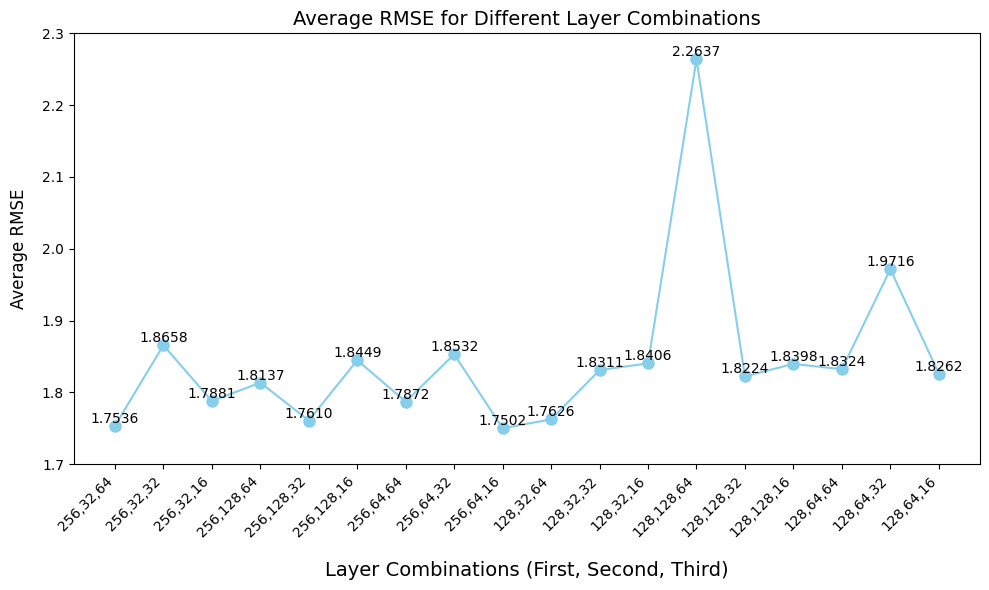

In [26]:
import matplotlib.pyplot as plt
import numpy as np

# Data: combinations and corresponding RMSE values
combinations = [
    (256, 32, 64), (256, 32, 32), (256, 32, 16), (256, 128, 64), (256, 128, 32), (256, 128, 16),
    (256, 64, 64), (256, 64, 32), (256, 64, 16), (128, 32, 64), (128, 32, 32), (128, 32, 16),
    (128, 128, 64), (128, 128, 32), (128, 128, 16), (128, 64, 64), (128, 64, 32), (128, 64, 16)
]

rmse_values = [
    1.7536, 1.8658, 1.7881, 1.8137, 1.7610, 1.8449,  
    1.7872, 1.8532, 1.7502, 1.7626, 1.8311, 1.8406, 
    2.2637, 1.8224, 1.8398, 1.8324, 1.9716, 1.8262
]

# Convert combinations to string labels for x-axis
labels = [f"{c[0]},{c[1]},{c[2]}" for c in combinations]

# Create the line chart
plt.figure(figsize=(10, 6))
plt.plot(labels, rmse_values, marker='o', linestyle='-', color='skyblue', markersize=8)

# Add labels and title
plt.xlabel('Layer Combinations (First, Second, Third)', fontsize=14,labelpad=15)
plt.ylabel('Average RMSE', fontsize=12,labelpad=10)
plt.title('Average RMSE for Different Layer Combinations', fontsize=14)

# Set y-axis range from 0.89 to 0.91
plt.ylim(1.7, 2.3)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Annotate each point with its RMSE value
for i, rmse in enumerate(rmse_values):
    plt.text(i, rmse, f'{rmse:.4f}', ha='center', va='bottom')

# Show the plot
plt.tight_layout()
plt.show()

Compare layer 

In [32]:
from sklearn.metrics import mean_squared_error
from math import sqrt
import numpy as np

def build_baseline_model(num_users, num_items, embedding_dim, num_layers):
    user_input = Input(shape=(1,), name='user_input')
    item_input = Input(shape=(1,), name='item_input')

    # Concatenating user and item inputs directly (no embeddings or MF)
    concatenated = Concatenate(name='concatenated_features')([user_input, item_input])

    # Dense layers based on the number of layers specified
    x = Dense(256, activation='relu', name='dense_256')(concatenated)
    if num_layers >= 3:
        x = Dense(128, activation='relu', name='dense_128')(x)
    if num_layers >= 2:
        x = Dense(32, activation='relu', name='dense_32')(x)

    # Output layer
    output = Dense(1, activation='linear', name='output')(x)

    # Create the model
    model = Model(inputs=[user_input, item_input], outputs=output, name=f'Baseline_Model_{num_layers}_layers')
    
    # Compile the model
    model.compile(optimizer='adam', loss='mse')
    
    return model




# Prepare lists to store RMSE values for different layer configurations
layer_rmse_results = {}

# Loop through different numbers of layers (4, 3, and 2 layers)
for num_layers in [4, 3, 2]:
    print(f"\nEvaluating model with {num_layers} layers:")
    
    # Create the model for the given number of layers
    model = build_baseline_model(num_users, num_items, embedding_dim, num_layers)

    # Train the model
    model.fit([user_ids_train, item_ids_train], ratings_train, epochs=5, batch_size=256, verbose=0)

    # Make predictions on the test data
    predictions = model.predict([user_ids_test, item_ids_test])

   
    rmse = sqrt(mean_squared_error(ratings_test, predictions))
    layer_rmse_results[num_layers] = rmse
    
    print(f"RMSE for model with {num_layers} layers: {rmse}")


print("\nRMSE for different layer configurations:")
for num_layers, rmse in layer_rmse_results.items():
    print(f"{num_layers} layers: {rmse}")



Evaluating model with 4 layers:
988/988 ━━━━━━━━━━━━━━━━━━━━ 0s 460us/step
RMSE for model with 4 layers: 1.6859987672225436

Evaluating model with 3 layers:
988/988 ━━━━━━━━━━━━━━━━━━━━ 0s 459us/step
RMSE for model with 3 layers: 1.6763241401659619

Evaluating model with 2 layers:
988/988 ━━━━━━━━━━━━━━━━━━━━ 0s 433us/step
RMSE for model with 2 layers: 1.5388670901849169

RMSE for different layer configurations:
4 layers: 1.6859987672225436
3 layers: 1.6763241401659619
2 layers: 1.5388670901849169


PLot

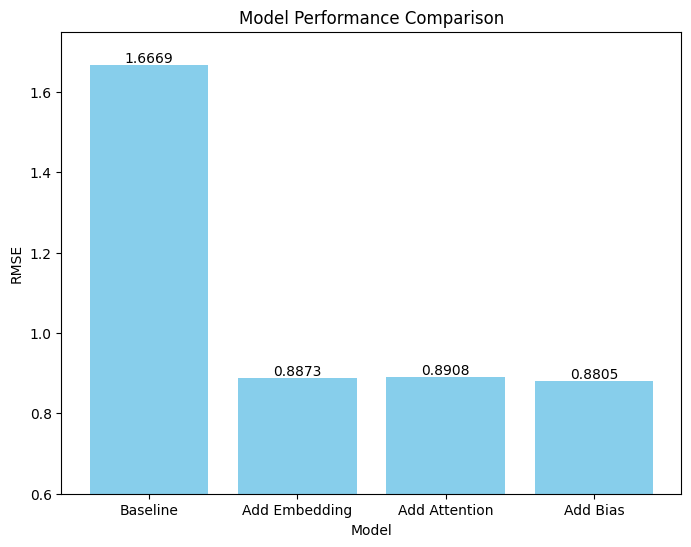

In [63]:
import matplotlib.pyplot as plt

# Data for the bar chart
models = ['Baseline', 'Add Embedding', 'Add Attention', 'Add Bias']
rmse_values = [1.6669, 0.8873, 0.8908, 0.8805]

# Create a bar chart
plt.figure(figsize=(8, 6))
bars = plt.bar(models, rmse_values, color='skyblue')

# Set labels and title
plt.ylabel('RMSE')
plt.xlabel('Model')
plt.title('Model Performance Comparison')

# Set y-axis range
plt.ylim(0.6, 1.75)

# Add RMSE values above each bar
for bar, value in zip(bars, rmse_values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() , 
             f'{value:.4f}', ha='center', va='bottom')

# Display the bar chart
plt.show()

